In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
import joblib
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

In [ ]:
train = os.listdir("../content/drive/Shareddrives/PiFlow/PiFlow/ProjectOPENCV/src/train/")

In [ ]:
test = os.listdir("../content/drive/Shareddrives/PiFlow/PiFlow/ProjectOPENCV/src/test/")

In [ ]:
def resize_all(src, pklname, include, width=2048, height=1536):
  """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
  data = dict()
  data['description'] = 'Bouchons images in rgb'.format(int(width), int(height))
  data['label'] = []
  data['filename'] = []
  data['data'] = []
  pklname = f"{pklname}_{width}x{height}px.pkl"

      # read all images in PATH, resize and write to DESTINATION_PATH
  for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [ ]:
# modify to fit your system
data_path_train = fr'../content/drive/Shareddrives/PiFlow/PiFlow/ProjectOPENCV/src/train/'

In [ ]:
data_path_test = fr'../content/drive/Shareddrives/PiFlow/PiFlow/ProjectOPENCV/src/test/'

In [ ]:
#Now we create the datasets
base_name_train = 'Bouchons_train'
base_name_test = 'Bouchons_test'
width=2048
height=1536
IMAGE_SIZE=(width, height)
include = {'BouchonRouge', 'BouchonVert', 'BouchonBleu', 'BouchonOrange', 'BouchonBlanc'}
resize_all(src=data_path_train, pklname=base_name_train, width=width, height=height, include=include)
resize_all(src=data_path_test, pklname=base_name_test, width=width, height=height, include=include)

In [ ]:
categories = []
for filename in train:
    category = filename.split('.')[0]
    if category == 'deform':
        categories.append(0)
    elif category == 'intacte_vert':
        categories.append(1)
    elif category == 'intacte_rouge':
        categories.append(2)

df = pd.DataFrame({
    'train': train,
    'category': categories
})

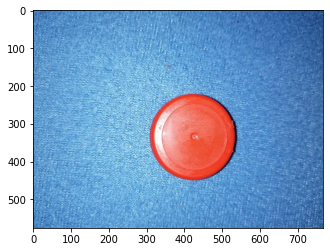

In [ ]:
sample = random.choice(train)
image = load_img(data_path_train+sample)
plt.imshow(image)

In [ ]:
#Data shuffle
from sklearn.utils import shuffle
data_train_deform=shuffle(df.loc[df["category"]==0])
data_train_intacte_vert=shuffle(df.loc[df["category"]==1])
data_train_intacte_rouge=shuffle(df.loc[df["category"]==2])

In [ ]:
#By convention, we name the input data X and result (labels) y.

data_train = joblib.load(f'{base_name_train}_{width}x{height}px.pkl')

X_train_deform = np.array(data_train_deform['train'])
y_train_deform = np.array(data_train_deform['category'])

X_train_intacte_rouge = np.array(data_train_intacte_rouge['train'])
y_train_intacte_rouge = np.array(data_train_intacte_rouge['category'])

X_train_intacte_vert = np.array(data_train_intacte_vert['train'])
y_train_intacte_vert = np.array(data_train_intacte_vert['category'])

data_test = joblib.load(f'{base_name_test}_{width}x{height}px.pkl')
X_test = np.array(data_test['data'])
y_test = np.array(data_test['label'])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage

# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(3,3), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

In [ ]:
# call fit_transform on each transform converting each X_train step by step

X_train_deform_gray = grayify.fit_transform(X_train_deform)
X_train_deform_hog = hogify.fit_transform(X_train_deform_gray)
X_train_deform_prepared = scalify.fit_transform(X_train_deform_hog)

print(X_train_deform_prepared.shape)

AttributeError: ignored

In [ ]:
X_train_intacte_rouge_gray = grayify.fit_transform(X_train_intacte_rouge)
X_train_intacte_rouge_hog = hogify.fit_transform(X_train_intacte_rouge_gray)
X_train_intacte_rouge_prepared = scalify.fit_transform(X_train_intacte_rouge_hog)

print(X_train_intacte_rouge_prepared.shape)

In [ ]:
X_train_intacte_vert_gray = grayify.fit_transform(X_train_intacte_vert)
X_train_intacte_vert_hog = hogify.fit_transform(X_train_intacte_vert_gray)
X_train_intacte_vert_prepared = scalify.fit_transform(X_train_intacte_vert_hog)

print(X_train_intacte_vert_prepared.shape)

In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_deform_prepared, y_train_deform)

In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_intacte_rouge_prepared, y_train_intacte_rouge)

In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_intacte_vert_prepared, y_train_intacte_vert)

In [ ]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [ ]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test, y_pred)
cmx

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))